In [1]:
import pandas as pd
import tensorflow as tf

DATA_PATH = '/home/kshipra/work/major/ml experiments/data/manually_combined.xlsx'

eos = pd.read_excel(DATA_PATH, sheet_name='all_stacked_eos')
sentinel = pd.read_excel(DATA_PATH, sheet_name='all_stacked_sentinel')
combined = pd.read_excel(DATA_PATH, sheet_name='eos_sent_combined')

len(eos), len(sentinel), len(combined)

2025-09-22 16:03:13.292113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(747, 796, 747)

In [2]:
X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

num_features = len(X_cols)

In [3]:
combined = combined[combined['SM (Combined)'] < 150]

combined

,VH,VV,Angle,SM (Sent),HH,HV,SM (EOS),SM (Combined),Unnamed: 8,Latitude (S),Longitude (S),Latitude (E),Longitude (E),Lat Diff,Long Diff,SM Diff
0,-14.947200,-10.379400,40.366800,20.6,-7.38713,-15.09099,24.4,22.50,NaN,22.526048,72.765011,22.526048,72.765011,0.000000,0.000000,-3.8
1,-16.361200,-11.299400,41.008800,25.8,-6.25740,-12.05392,41.0,33.40,NaN,22.525481,72.765028,22.525481,72.765028,0.000000,0.000000,-15.2
2,-16.168800,-10.992000,42.359800,28.9,-8.44134,-16.46069,25.3,27.10,NaN,22.525423,72.765663,22.525423,72.765663,0.000000,0.000000,3.6
3,-15.630700,-8.829090,42.982700,4.1,-2.85467,-17.00499,53.7,28.90,NaN,22.525999,72.765663,22.525999,72.765663,0.000000,0.000000,-49.6
4,-15.130900,-10.333000,41.434700,35.3,-6.88868,-12.32378,53.4,44.35,NaN,22.525563,72.765399,22.525563,72.765399,0.000000,0.000000,-18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-15.603123,-10.557852,42.709682,30.2,-8.69274,-14.15688,26.8,28.50,NaN,22.505581,72.764064,22.523640,72.766727,-0.018059,-0.002663,3.4
743,-16.321512,-11.300431,42.176147,38.3,-6.48271,-15.56076,32.8,35.55,NaN,22.505961,72.764083,22.523657,72.766016,-0.017696,-0.001933,5.5
744,-15.585269,-11.489754,42.523727,20.0,-6.20660,-14.73141,34.8,27.40,NaN,22.506133,72.763434,22.524255,72.766024,-0.018122,-0.002590,-14.8
745,-16.052544,-10.954885,42.562408,39.7,-9.43414,-20.52987,27.8,33.75,NaN,22.505784,72.763859,22.524229,72.766601,-0.018445,-0.002742,11.9


In [4]:
from tqdm import tqdm

class EpochTqdm(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, desc="Epochs"):
        super().__init__()
        self.pbar = tqdm(total=total_epochs, desc=desc, unit="epoch")
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # show loss/val_loss nicely (change keys as needed)
        postfix = {}
        if "loss" in logs: postfix["loss"] = f"{logs['loss']:.4f}"
        if "val_loss" in logs: postfix["val_loss"] = f"{logs['val_loss']:.4f}"
        if postfix:
            self.pbar.set_postfix(postfix)
        self.pbar.update(1)
    def on_train_end(self, logs=None):
        self.pbar.close()

# Tube Loss

In [5]:
# hyperparameters for Tube Loss
q = 0.95 # target coverage
r=0.5  # for movement of PI tube
delta = 0 #  for recalibration


def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) + (delta * tf.abs(f1 - f2))

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)

In [6]:
from model_experiments import PredictionIntervalEstimation
from tensorflow import keras

tf.keras.backend.clear_session()

model1 = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model3 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model = model3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss=confidence_loss, optimizer=opt)

In [7]:
exp = PredictionIntervalEstimation(combined, features=X_cols, target=y_col[0])

X_train_scaled = exp.X_train_scaled
y_train = exp.y_train
X_val_scaled = exp.X_val_scaled
y_val = exp.y_val
X_test_scaled = exp.X_test_scaled
y_test = exp.y_test

In [8]:
num_epochs = 50
history =  model.fit(
    X_train_scaled, y_train,
    epochs=num_epochs,
    batch_size=32,
    verbose=0,
    validation_data=(X_val_scaled, y_val),
    callbacks=[EpochTqdm(total_epochs=num_epochs)]
)

Epochs: 100%|██████████| 50/50 [00:04<00:00, 10.48epoch/s, loss=0.6253, val_loss=0.6607] 


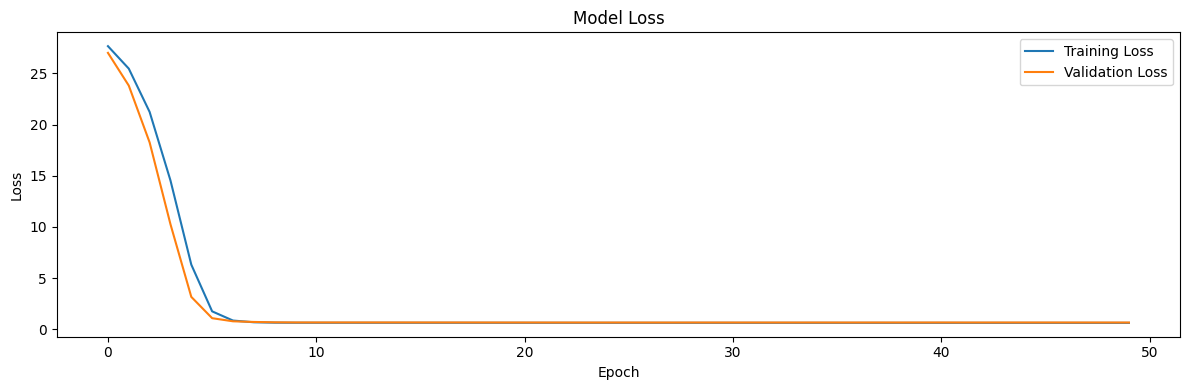

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
# Calculating Evaluation Criteria
y_pred = model.predict(X_test_scaled, verbose=0)
y_test = np.stack((y_test, y_test),axis=1)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_test[:,0]
K_l = y_l_pred < y_test[:,0]
picp = np.mean(K_u * K_l)
mpiw = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', picp)
print('MPIW:', mpiw)

PICP: 0.96
MPIW: 30.777


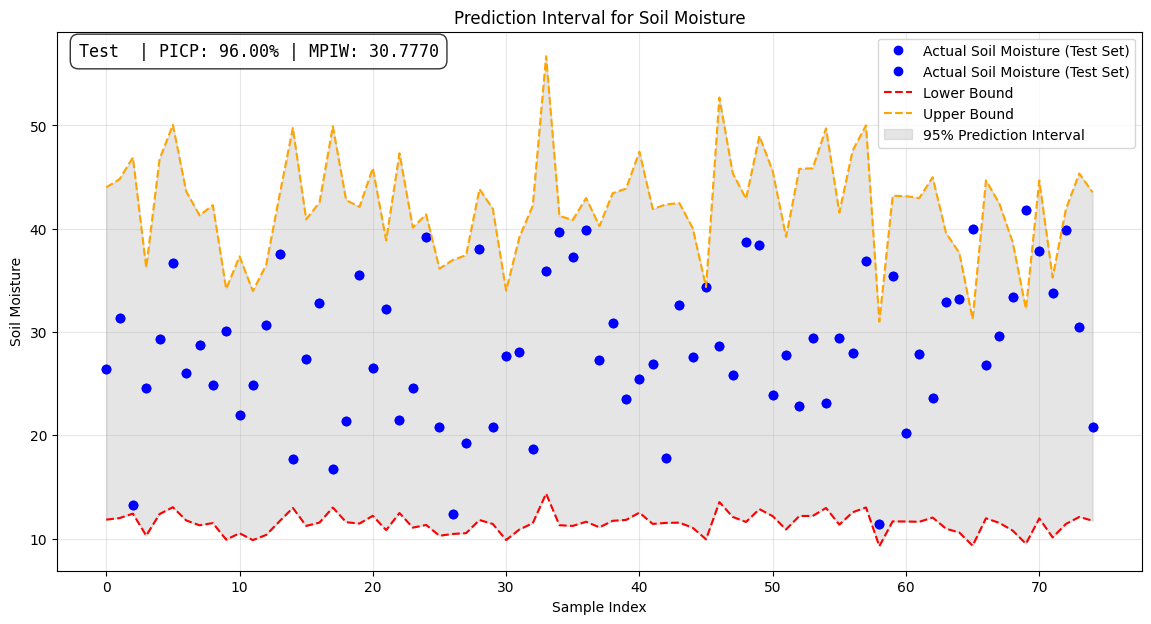

In [11]:
def plot_prediction_interval(y_test, y_pred_lower_test, y_pred_upper_test, picp, mpiw):
    indices = range(len(y_test))

    # Calculate metrics for both test and validation sets

    plt.figure(figsize=(14, 7))
    plt.plot(indices, y_test, 'o', color='blue', label='Actual Soil Moisture (Test Set)')
    plt.plot(indices, y_pred_lower_test, color='red', linestyle='--', label='Lower Bound')
    plt.plot(indices, y_pred_upper_test, color='orange', linestyle='--', label='Upper Bound')

    plt.fill_between(indices, y_pred_lower_test, y_pred_upper_test, color='gray', alpha=0.2, label='95% Prediction Interval')

    # Create a clean, aligned text box for both metrics
    test_metrics = f"Test  | PICP: {picp*100:5.2f}% | MPIW: {mpiw:.4f}"
    metrics_text = f"{test_metrics}"
    
    plt.annotate(metrics_text, xy=(0.02, 0.98), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8), 
                verticalalignment='top', fontsize=12,
                # Using a monospaced font for clean alignment
                fontname='monospace')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Soil Moisture')
    plt.title(f'Prediction Interval for Soil Moisture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_prediction_interval(y_test, y_l_pred, y_u_pred, picp, mpiw)